# Прогнозирование уровня средней заработной платы в России

In [46]:
# Импортирование необходимых библиотек по аналогии с приведенным в практике примером 

%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/anton/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Визуальный анализ ряда

Для первоначального анализа необходимо посмотреть на временной ряд зарплат так, как он есть, а затем на расзложение его на компоненты тренда, сезонности и цикличности. <br><br>
После применения критерия Дики-Фуллера, можно сделать выводо стационарности исходного ряда

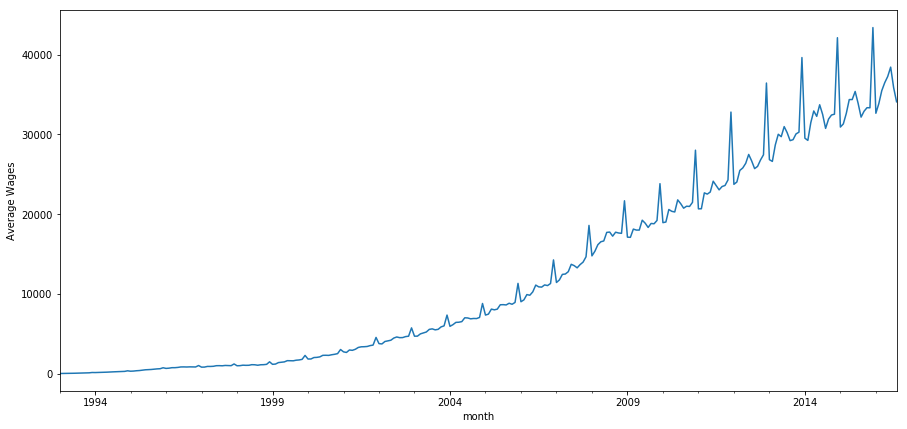

,wages
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [47]:
# Считываем даные из файла и переименовываем колонку с временным рядом

wages = pd.read_csv('./WAG_C_M.csv', ";", index_col="month", parse_dates=["month"], dayfirst=True)
wages.columns = ["wages"]
plt.figure(figsize(15,7))
wages.wages.plot()
plt.ylabel('Average Wages')
pylab.show()

wages.head()

Уже на данном этапе в ряде заметен явно выраженный восходящий тренд, который явно свидетельствует о нестационарности ряда. Проведем STL декомпозицию.

Критерий Дики-Фуллера: p=0.991850


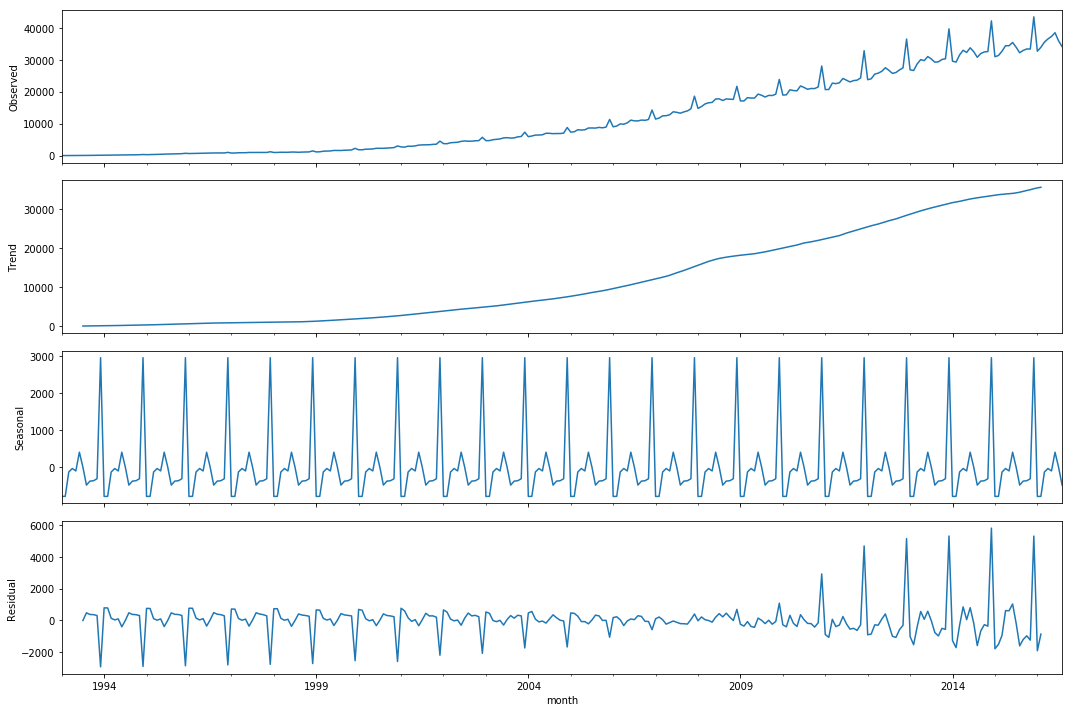

In [48]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages)[1])

Помимо восходящего тренда в ряде присутствует гетероскедастичность, таким образом необходимо провести преобразование Бокса-Кокса для стабилизации дисперсии.

### 2. Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


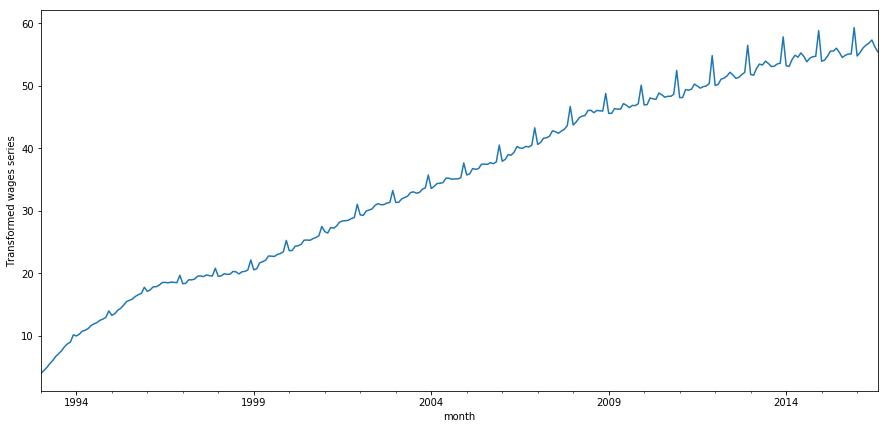

In [49]:
# Проводим преобразование Бокса-Кокса и сохрянем преобразованные занчение в новую колонку датафрейма

wages["wages_box"], lmbda = stats.boxcox(wages.wages)
plt.figure(figsize(15,7))
wages.wages_box.plot()
plt.ylabel(u'Transformed wages series')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box)[1])

Значение критерия Дики-Фуллера изменилось в меньшую сторону, но некоторый разброс дисперсии во времени сохранился. Продолжим преобразование ряда для приведения его к стационарному виду.

### 3. Выбор порядка дифференцирования

Для избавления от автокорреляционных завивимостей в ряде проведем дифференциальные преобразования для сезонного и при необходимости несезонного лагов.

Критерий Дики-Фуллера: p=0.014697


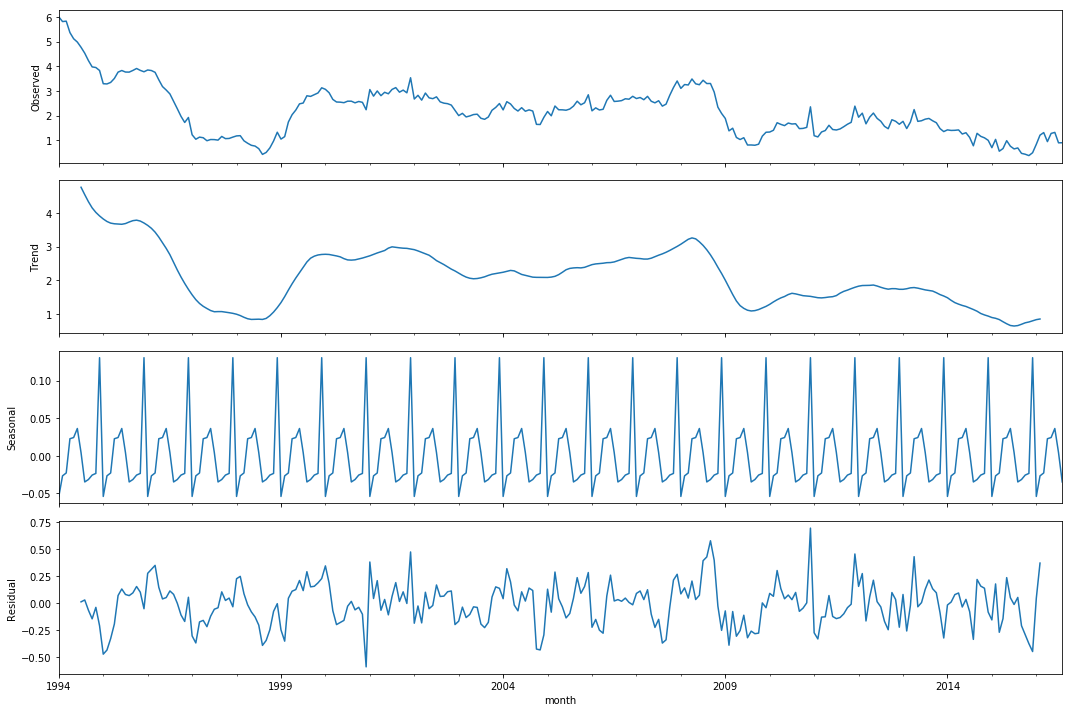

In [50]:
# Вычитаем сезонную составляющая из нашего ряда. Так как мы имеем дело с месячными данными, необходимо
# сдвигать ряд на 12 значений вперед по колчиеству месяцев в году.

wages['wages_box_diff'] = wages.wages_box - wages.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.wages_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности преобразованного ряда на уровне значимости 5%. Продолжим работать с полученными данными.

### 4. Выбор начальных приближений для p,q,P,Q

На основе графиков корреляций и частичных корреляций (ACF и PACF) выберем начальное приближение для параметров p, q, P и Q.

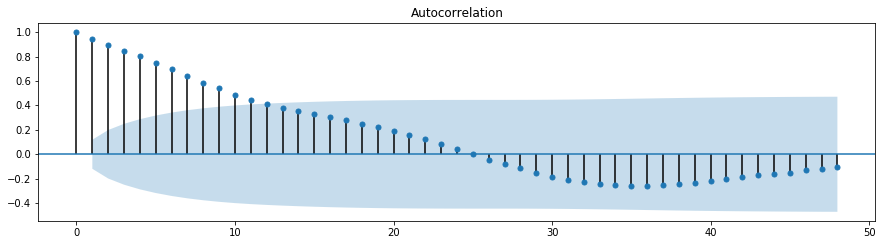

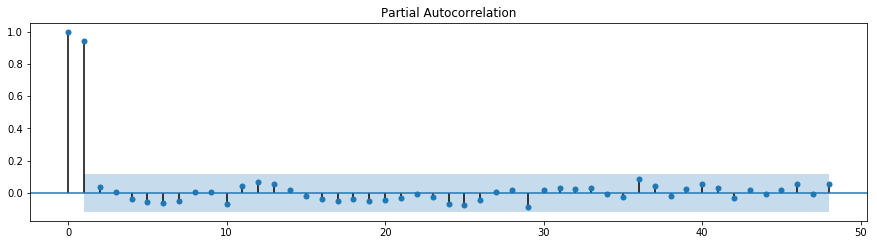

In [51]:
# Построим ACF и PACF графики для выбора приближения на их основе

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wages.wages_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wages.wages_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=11, P=0, p=1. Составим решетку для подбора параметров SARIMA модели.

In [52]:
# Решетка значений для подбора оптимальных параметров модели

ps = range(0, 2)
d=0
qs = range(0, 12)
Ps = range(0, 1)      # Значимых сезонных показателей не обнаружено
D=1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

Для нахождения лучшей модели пройдемся по решетке из parameters_list и выберем лучшую по критерию Акаике модель.

In [34]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 3, 0, 0)
wrong parameters: (0, 3, 0, 1)
wrong parameters: (0, 4, 0, 0)
wrong parameters: (0, 4, 0, 1)
wrong parameters: (0, 5, 0, 0)
wrong parameters: (0, 5, 0, 1)
wrong parameters: (0, 6, 0, 0)
wrong parameters: (0, 6, 0, 1)
wrong parameters: (0, 7, 0, 0)
wrong parameters: (0, 7, 0, 1)
wrong parameters: (0, 8, 0, 0)
wrong parameters: (0, 8, 0, 1)
wrong parameters: (0, 9, 0, 0)
wrong parameters: (0, 9, 0, 1)
wrong parameters: (0, 10, 0, 0)
wrong parameters: (0, 10, 0, 1)
wrong parameters: (0, 11, 0, 0)
wrong parameters: (0, 11, 0, 1)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 4, 0, 1)
wrong parameters: (1, 5, 0, 1)
wrong parameters: (1, 6, 0, 1)
wrong parameters: (1, 7, 0, 1)
wrong parameters: (1, 8, 0, 1)
wrong parameters: (1, 9, 0, 1)
wron

In [53]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters       aic
11   (1, 9, 0, 0) -7.881018
12  (1, 10, 0, 0) -6.598183
13  (1, 11, 0, 0) -5.127432
10   (1, 8, 0, 0) -4.342940
9    (1, 7, 0, 0) -2.680371


Лучшая модель по критерию Акаике

In [54]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          wages_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(0, 1, 0, 12)   Log Likelihood                  14.941
Date:                            Tue, 07 Nov 2017   AIC                             -7.881
Time:                                    22:47:06   BIC                             32.258
Sample:                                01-01-1993   HQIC                             8.211
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9894      0.007    139.879      0.000       0.976       1.003
ma.L1         -0.1913      0.049   

### 6. Анализ остатков построенной модели

Проведем анализ остатков на несмещенность и отсутствие автокорреляции и нестационарности. Несмещенность будем проверять с помощью критерия Стьюдента. Стационарность с помощью критерия Дики-Фуллера.

Критерий Стьюдента: p=0.990453
Критерий Дики-Фуллера: p=0.000000


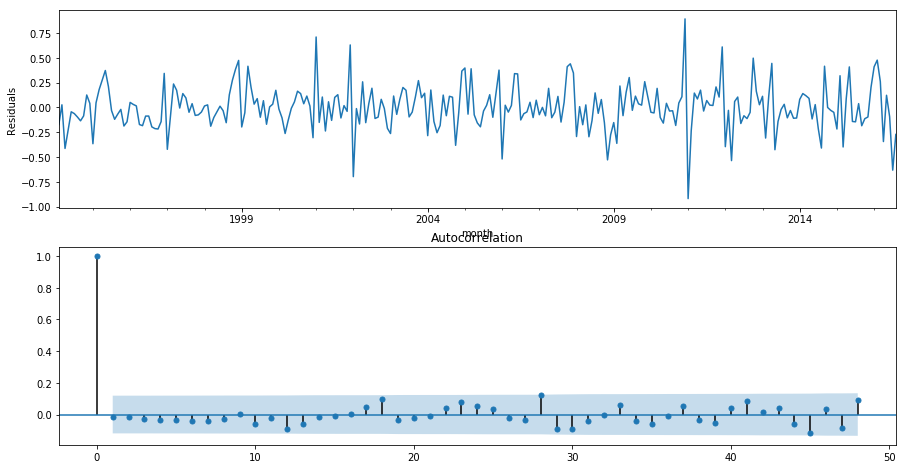

In [55]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Исходя из полученных уровней значимости, можно заключить, что гипотезы о смещенности, нестационарности и автокоррелированоости ошибок отвергаются.

### 7. Прогнозирование с помощью финальной модели.

На основе коэффициентов наилучшей из подобранных моделей сделаем расчет модельных значений и сделаем прогноз на два года вперед.

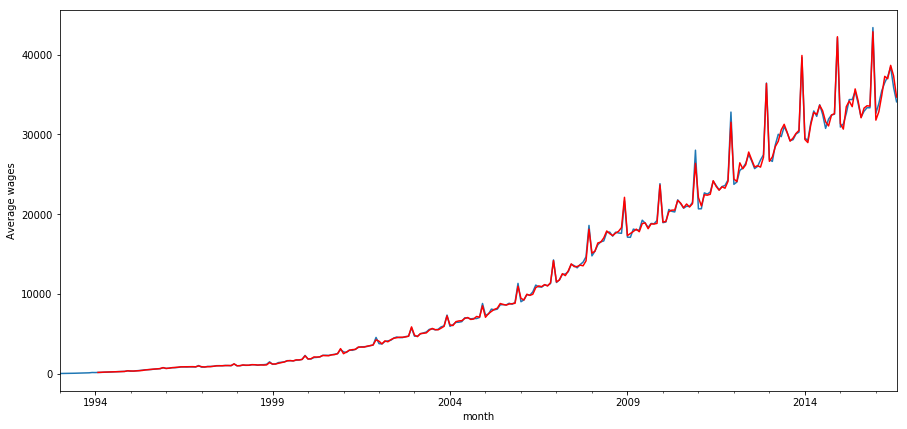

In [56]:
# Производим расчет модельных значений и строим график сравнения с реальными значениями

wages['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.wages.plot()
wages.model[13:].plot(color='r')
plt.ylabel('Average wages')
pylab.show()

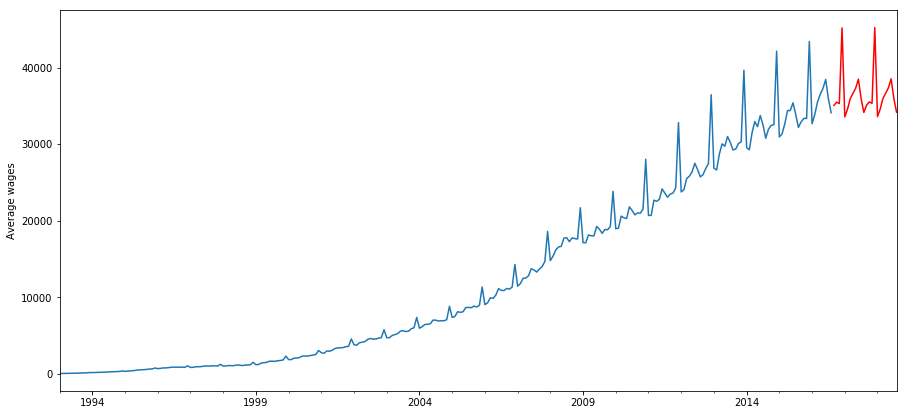

In [62]:
# Производим рассчет прогнозных значений

wages2 = wages[['wages']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['forecast'] = invboxcox(best_model.predict(start=wages.shape[0], end=wages.shape[0] + 24), lmbda)

plt.figure(figsize(15,7))
wages2.wages.plot()
wages2.forecast.plot(color='r')
plt.ylabel('Average wages')
pylab.show()